# **Laboratorio 3 - Informe**

### Grupo 4:
     - S. Calvo C.I 5.711.417-7     
     - X. Iribarnegaray C.I 5.253.705-9
     - J. Simonelli C.I 5.405.358-4

### **Objetivos**
El objetivo de este laboratorio es:
- Implementar funciones de AgenteRL para el ambiente open-ai gymnassium
- Analizar los resultados obtenidos luego de ejecuciones del agente entrenado
- Fundamentar la elección de los hiperparámetros utilizados

### **1. Bibliotecas**

In [1]:
!pip3 install cmake gymnasium scipy numpy gymnasium[box2d] pygame==2.6.0 swig
import sys
# Tal vez tengan que ejecutar lo siguiente en sus máquinas (ubuntu 20.04)
# sudo apt-get remove swig
# sudo apt-get install swig3.0
# sudo ln -s /usr/bin/swig3.0 /usr/bin/swig
# En windows tambien puede ser necesario MSVC++
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import json


Defaulting to user installation because normal site-packages is not writeable


## **2. Discretizando el estado**

El estado consiste de posiciones y velocidades en (x,y,theta) y en información de contacto de los pies con la superficie.

Como varios de estos son continuos, tenemos que discretizarlos para aplicar nuestro algoritmo de aprendizaje por refuerzo tabular.

In [2]:
# Cuántos bins queremos por dimensión
# Pueden considerar variar este parámetro
bins_per_dim = 20

# Estado:
# (x, y, x_vel, y_vel, theta, theta_vel, pie_izq_en_contacto, pie_derecho_en_contacto)
NUM_BINS = [bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, 2, 2]

env = gym.make('LunarLander-v2')
env.reset()

# Tomamos los rangos del env
OBS_SPACE_HIGH = env.observation_space.high
OBS_SPACE_LOW = env.observation_space.low
OBS_SPACE_LOW[1] = 0 # Para la coordenada y (altura), no podemos ir más abajo que la zona dea aterrizae (que está en el 0, 0)

# Los bins para cada dimensión
bins = [
    np.linspace(OBS_SPACE_LOW[i], OBS_SPACE_HIGH[i], NUM_BINS[i] - 1)
    for i in range(len(NUM_BINS) - 2) # last two are binary
]
# Se recomienda observar los bins para entender su estructura
# print ("Bins: ", bins[1])

def discretize_state(state, bins):
    """Discretize the continuous state into a tuple of discrete indices."""
    state_disc = list()
    for i in range(len(state)):
        if i >= len(bins):  # For binary features (leg contacts)
            state_disc.append(int(state[i]))
        else:
            state_disc.append(
                np.digitize(state[i], bins[i])
            )
    return tuple(state_disc)

## **3. Agentes y la interacción con el entorno**

Definimos una interfaz para nuestro agente:

In [3]:
class Agente:
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        """Elegir la accion a tomar en el estado actual y el espacio de acciones
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó
        """
        pass

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        """Aprender a partir de la tupla 
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó en esta transición
        """
        pass

    def fin_episodio(self):
        """Actualizar estructuras al final de un episodio"""
        pass

Luego definimos la función `ejecutar_episodio` para ejecutar un episodio con el agente AgenteRL:

In [4]:
def ejecutar_episodio(agente, aprender, render, max_iteraciones=500):
    if (render):
        entorno = gym.make('LunarLander-v2', render_mode='human').env
    else: 
        entorno = gym.make('LunarLander-v2').env
    
    iteraciones = 0
    recompensa_total = 0

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset()
    while iteraciones < max_iteraciones and not termino and not truncado:
        if render:
            entorno.render()
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n, aprender)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # print(estado_siguiente)
        # Le informamos al agente para que aprenda
        if (aprender):
            agente.aprender(estado_anterior, estado_siguiente, accion, recompensa, termino)

        estado_anterior = estado_siguiente
        iteraciones += 1
        recompensa_total += recompensa
    if (aprender):
        agente.fin_episodio(recompensa_total)
    entorno.close()
    return recompensa_total

### **4. Programando un agente que aprende**

A continuación implementamos el agente:

In [5]:
class AgenteRL(Agente):
    # Pueden agregar parámetros al constructor
    def __init__(self, states, actions, gamma, initial_epsilon, final_epsilon, decay_factor) -> None:
        super().__init__()
        self.Q = np.zeros((states,actions))
        self.visits = np.zeros((states, actions))
        self.gamma = gamma
        self.epsilon = initial_epsilon
        self.final_epsilon = final_epsilon
        self.recompensa_maxima = -np.inf
        self.decay_factor = decay_factor
        self.threshold = 0
            
    def estado_discretizado_a_indice(self, estado_discretizado):
        return estado_discretizado[0] * 12800000 + estado_discretizado[1] * 640000 + estado_discretizado[2] * 32000 + \
           estado_discretizado[3] * 1600 + estado_discretizado[4] * 80 + estado_discretizado[5] * 4 + \
           estado_discretizado[6] * 2 + estado_discretizado[7]
           
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        estado_discretizado = discretize_state(estado, bins)
        row = self.estado_discretizado_a_indice(estado_discretizado)
        
        if explorar and np.random.random() < self.epsilon:
            return random.randrange(max_accion)  # Exploración
        else:
            return np.argmax(self.Q[row])  # Explotación
    
    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        discretized_state_anterior = discretize_state(estado_anterior, bins)
        discretized_state_siguiente = discretize_state(estado_siguiente, bins)
        
        row_anterior = self.estado_discretizado_a_indice(discretized_state_anterior)
        self.visits[row_anterior, accion] += 1
        alpha_n = 1 / self.visits[row_anterior, accion]

        row_siguiente = self.estado_discretizado_a_indice(discretized_state_siguiente)
        
        # Fórmula de actualización de Q-learning
        if not terminado:
            self.Q[row_anterior][accion] = (1 - alpha_n) * self.Q[row_anterior][accion] + alpha_n * (recompensa + self.gamma * np.max(self.Q[row_siguiente]))
        else:
            # Si el episodio terminó, no hay valor de futuro
            self.Q[row_anterior][accion] = (1 - alpha_n) * self.Q[row_anterior][accion] + alpha_n * (recompensa)

    def fin_episodio(self, recompensa_total):
        if recompensa_total > self.threshold: 
            self.epsilon = max(self.final_epsilon, self.epsilon*self.decay_factor)
            self.threshold += 1
        

#### **4.1 Diseño**

Nuestra implementación del agente sigue un flujo iterativo donde el agente aprende a maximizar su recompensa mediante la interacción continua con el entorno. Utilizamos una política epsilon-greedy para balancear entre la exploración de nuevas acciones y la explotación de las acciones que ya ha experimentado. El objetivo es aprender una función de valor $Q(s,a)$, que estima las recompensas esperadas para cada par de estado $s$ y acción $a$.

##### Parámetros
- **states**: Número total de estados posibles. Esto define la cantidad de filas de la matriz $Q$, que almacena los valores esperados de recompensa para cada combinación de estado y acción.
- **actions**: Número total de acciones posibles que el agente puede tomar en cada estado. Cada fila de la matriz $Q$ tiene una columna para cada acción.
- **gamma**: Factor de descuento ($\gamma$). Define la importancia de las recompensas futuras frente a las recompensas inmediatas. Un
$γ$ alto hace que el agente valore más las recompensas a largo plazo.
- **initial_epsilon**: Valor inicial de $\epsilon$, que controla la probabilidad inicial de que el agente explore (tome una acción aleatoria) en lugar de explotar (tomar la mejor acción según la matriz $Q$).
- **final_epsilon**: Valor mínimo que puede alcanzar $\epsilon$. Aunque $\epsilon$ disminuye durante el entrenamiento, nunca cae por debajo de este valor, garantizando que siempre haya un pequeño grado de exploración (si este valor es mayor a 0).
- **decay_factor**: Factor multiplicativo utilizado para reducir $\epsilon$ al final de cada episodio en función de las recompensas obtenidas. Un decaimiento controlado asegura una transición suave entre exploración y explotación.


#### Inicializacion
El constructor inicializa los parámetros y estructuras necesarias para que el agente aprenda en un entorno de aprendizaje por refuerzo.

- $Q$: Matriz de dimensiones $states \times actions$, inicializada en ceros, que almacena los valores $Q(s,a)$.
- **$visits$**: Matriz para contar el numero de veces que el agente ha visitado cada combinación de estado-acción.
- **$recompensa\_maxima$**: Variable para almacenar la mayor recompensa que obtuvo el agente a lo largo de los episodios ejecutados.

#### Estado discretizado a índice

Esta función convierte un estado discretizado en un índice único que se usa para acceder a la matriz $Q$. Dado que el entorno tiene un espacio de estados continuo o de alta dimensionalidad, esta función es esencial para almacenar los valores de $Q$ de manera eficiente.

La función recibe un estado discretizado representado como un vector de 8 componentes. Los primeros 6 componentes del vector pueden tomar 20 valores distintos (0 a 19), mientras que los últimos 2 pueden tomar solo 2 valores (0 y 1). Para transformar este vector en un índice único, se utiliza una fórmula que combina linealmente los componentes del estado con factores de escalamiento.

**Fórmula**:
$$\text{índice} = s_0 \times 12800000 + s_1 \times 640000 + s_2 \times 32000 + s_3 \times 1600 + s_4 \times 80 + s_5 \times 4 + s_6 \times 2 + s_7
$$

**Obs**: $12800000 = states / 20$, $640000 = 12800000 / 20$, ..., $2 = 4 / 2$, $1 = 2 / 2$

Esta técnica asegura que cada combinación única de valores de estado discretizado tenga un índice único

#### Elegir acción

Esta función implementa la política **epsilon_greedy** que balancea la exploración y explotación.

Recibe el estado actual del entorno, lo discretiza, y luego selecciona una acción aleatoria con probabilidad $\epsilon$ o la acción con el mayor valor de $Q(s,a)$ con probabilidad $1-\epsilon$.

#### Aprender
Esta función es responsable de actualizar los valores de $Q(s,a)$ después de cada paso en el entorno, utilizando la ecuación de Bellman.

Recibe el estado anterior y el siguiente estado, junto con la acción tomada, la recompensa recibida, y una bandera que indica si el episodio ha terminado y actualiza el valor de $Q(s,a)$ correspondiente al estado anterior y la acción tomada.

**Pasos**:
1. Discretiza los estados $s_t$ (estado_anterior) y $s_{t+1}$ (estado_siguiente).
2. Calcula la tasa de aprendizaje 
$$\alpha_n = 1/(visits(s_t, a_t))$$
3. Si el episodio no ha terminado, utiliza la fórmula de Q-learning:
$$Q(s_t, a_t) = (1 - \alpha) Q(s_t, a_t) + \alpha \left[ r_t + \gamma \max_a Q(s_{t+1}, a) \right]$$
4. Si el episodio ha terminado, la fórmula se reduce a:
$$Q(s_t, a_t) = (1 - \alpha) Q(s_t, a_t) + \alpha r_t$$

#### Fin Episodio

Esta función ajusta el valor de $\epsilon$ al final de cada episodio.

Recibe la recompensa total obtenida en el episodio. Si la recompensa supera el umbral actual, se ajusta $\epsilon$ multiplicándolo por el $decay\_factor$, y se incrementa este umbral en 1. Inicialmente, este parámetro es igual a 0, por lo que solo se vería incrementado si obtenemos una recompensa positiva en el episodio, y a medida que el entrenamiento transcurre y el agente obtiene más recompensas totales positivas mayores al umbral, y a medida que el entrenamiento avanza, el agente ajustará su comportamiento para alcanzar objetivos de mayor recompensa antes de que $\epsilon$ se reduzca nuevamente. Esto permite un enfoque basado en el rendimiento, donde el agente necesita demostrar mejoras claras antes de reducir su grado de exploración.

Este enfoque sigue la idea del Reward Based Decay, donde el valor de $\epsilon$ disminuye solo después de que el agente ha demostrado aprender al alcanzar un umbral de recompensa definido. En lugar de suponer que el agente mejora con cada episodio, se establece un criterio que asegura una reducción de $\epsilon$ solo si el agente ha alcanzado un objetivo claro, evitando así un decremento prematuro de la exploración que podría afectar el aprendizaje.

**Pasos**:

1. Si la recompensa total es mayor que el umbral $threshold$ actual, reduce $\epsilon$ y se asegura que $\epsilon$ nunca caiga por debajo de $final\_epsilon$.
2. Actualiza el umbral (`threshold += 1`).

Este ajuste dinámico de $\epsilon$ permite que el agente explore más al principio y, cuando mejora su rendimiento, reduzca la exploración para explotar lo aprendido.


### **5. Entrenamiento**

A continuación entrenaremos el agente con 100.000 episodios, para luego evaluar su desempeño con 1000 episodios de evaluación. Junto con el entrenamiento evaluaremos el decrecimiento del epsilon, la recompensa promedio cada 10.000 episodios, y la frecuencia de éxitos cada 1000 episodios, con el fin de analizar la mejora del agente a lo largo del entrenamiento.

In [6]:
entorno = gym.make('LunarLander-v2').env
episodios = 100_000
agente = AgenteRL(np.prod(NUM_BINS),entorno.action_space.n,1,initial_epsilon=1,final_epsilon=0.1,decay_factor=0.9)

exitos = 0
recompensa_acumulada_intervalo = []
exitos_intervalo_array = []
exitos_intervalo = 0
recompensas = []
epsilons = []
intervalos = 1000

for i in range(episodios):
    recompensa = ejecutar_episodio(agente, aprender=True, render=False)
    if (recompensa >= 200):
        exitos += 1
        exitos_intervalo += 1
    recompensa_acumulada_intervalo += [recompensa]
    if (i % intervalos == 0):
        print('Episodio', i,'- Promedio de últimas', intervalos ,'iteraciones: ', np.mean(recompensa_acumulada_intervalo),'- Epsilon:', agente.epsilon, '- Threshold:', agente.threshold)
        recompensas.append(np.mean(recompensa_acumulada_intervalo))
        epsilons.append(agente.epsilon)
        exitos_intervalo_array.append(exitos_intervalo)
        exitos_intervalo = 0
        recompensa_acumulada_intervalo = []

Episodio 0 - Promedio de últimas 1000 iteraciones:  -350.3809130202644 - Epsilon: 1 - Threshold: 0
Episodio 1000 - Promedio de últimas 1000 iteraciones:  -162.1970749248288 - Epsilon: 0.10941898913151243 - Threshold: 21
Episodio 2000 - Promedio de últimas 1000 iteraciones:  -140.16464023707522 - Epsilon: 0.1 - Threshold: 46
Episodio 3000 - Promedio de últimas 1000 iteraciones:  -128.57994636005037 - Epsilon: 0.1 - Threshold: 57
Episodio 4000 - Promedio de últimas 1000 iteraciones:  -127.55312860382121 - Epsilon: 0.1 - Threshold: 65
Episodio 5000 - Promedio de últimas 1000 iteraciones:  -121.62281827882282 - Epsilon: 0.1 - Threshold: 76
Episodio 6000 - Promedio de últimas 1000 iteraciones:  -116.01976357760871 - Epsilon: 0.1 - Threshold: 92
Episodio 7000 - Promedio de últimas 1000 iteraciones:  -114.4443803733085 - Epsilon: 0.1 - Threshold: 109
Episodio 8000 - Promedio de últimas 1000 iteraciones:  -109.06560824376342 - Epsilon: 0.1 - Threshold: 130
Episodio 9000 - Promedio de últimas 1

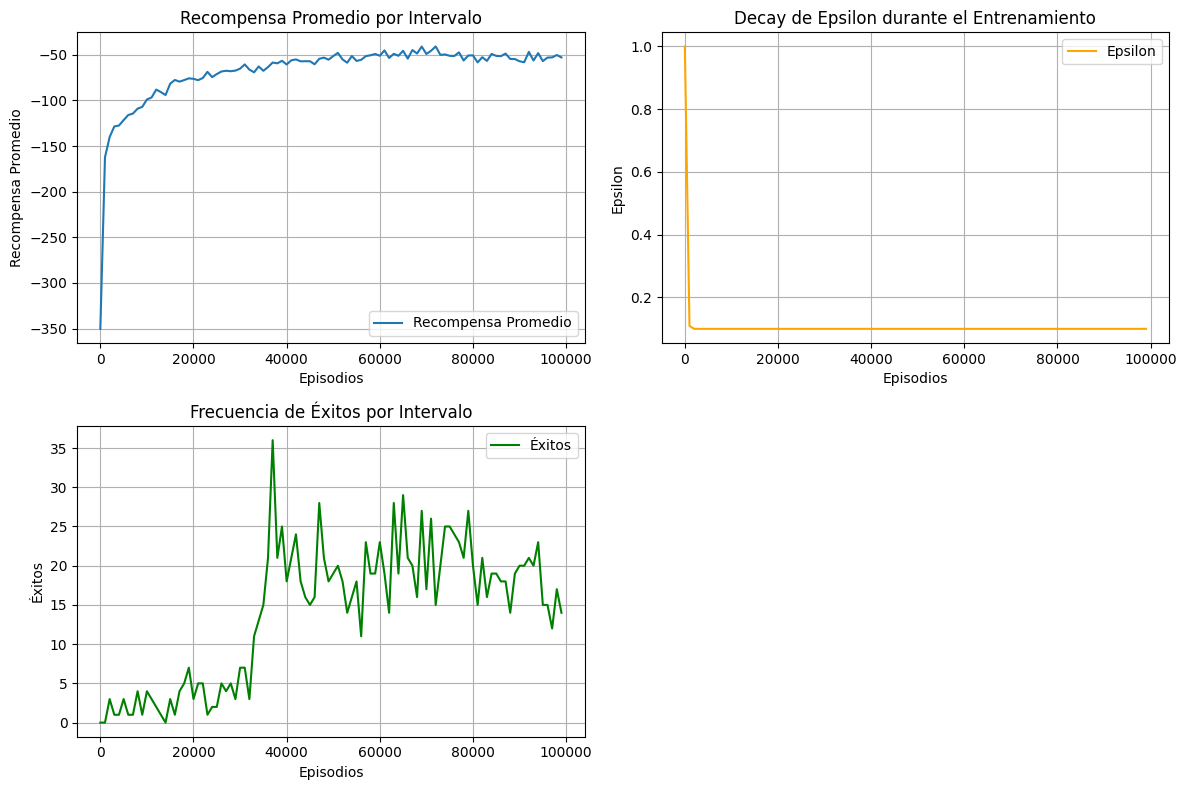

In [7]:
episodios_plot = range(0, episodios, intervalos)

# Crear la figura y los ejes
plt.figure(figsize=(12, 8)) 

# Primera gráfica: Recompensas en función de episodios
plt.subplot(2, 2, 1)
plt.plot(episodios_plot, recompensas, label='Recompensa Promedio')
plt.xlabel('Episodios')
plt.ylabel('Recompensa Promedio')
plt.title('Recompensa Promedio por Intervalo')
plt.grid(True)
plt.legend()

# Segunda gráfica: Epsilon en función de episodios
plt.subplot(2, 2, 2)
plt.plot(episodios_plot, epsilons, label='Epsilon', color='orange')
plt.xlabel('Episodios')
plt.ylabel('Epsilon')
plt.title('Decay de Epsilon durante el Entrenamiento')
plt.grid(True)
plt.legend()

# Tercera gráfica: Éxitos en función de episodios
plt.subplot(2, 2, 3)
plt.plot(episodios_plot, exitos_intervalo_array, label='Éxitos', color='green')
plt.xlabel('Episodios')
plt.ylabel('Éxitos')
plt.title('Frecuencia de Éxitos por Intervalo')
plt.grid(True)
plt.legend()

# Ajustar automáticamente los espacios entre subplots
plt.tight_layout()

# Mostrar las gráficas
plt.show()


A través del gráfico de recompensas promedio cada 1000 episodios, observamos que inicialmente el agente recibe recompensas negativas bajas, lo que indica un desempeño deficiente en el aterrizaje (choques o aterrizajes ineficientes). Sin embargo, a medida que avanza el entrenamiento, el agente mejora gradualmente su desempeño, alcanzando un promedio de recompensa cercano a -50. Esto sugiere que el agente está aprendiendo a aterrizar de manera más segura y controlada con el tiempo. Sin embargo, la recompensa promedio sigue siendo negativa, por lo que no estamos teniendo una tasa de éxito ideal.

Luego, en el gráfico de decaimiento del epsilon, como era de esperarse, al ser el factor de decaimiento `decay_factor = 0.9`, el espilon disminuye al mínimo en las primeras 1000 iteraciones, dando mayor énfasis a la explotación sobre la exploración para el resto de episodios. Aún así, con el valor mínimo de epsilon establecido, por cada iteración se mantendrá un 10% de probabilidad de exploración, permitiendo que esto aún ocurra a lo largo del entrenamiento.

Por último, es observable que existe una tendencia a la mejora en la frecuencia de éxitos del agente, indicando que efectivamente está aprendiendo y obteniendo aterrizajes exitosos

In [117]:
exitos = 0
num_episodios = 1000
recompensa_episodios = []
for i in range(num_episodios):
    recompensa = ejecutar_episodio(agente, aprender=False, render=False)
    # Los episodios se consideran exitosos si se obutvo 200 o más de recompensa total
    if (recompensa >= 200):
        exitos += 1
        # print('it', i, ' Exito: ',recompensa)
    recompensa_episodios += [recompensa]
    
print(f"Porcentaje de éxitos: {((exitos / num_episodios) * 100):.2f}%. Se obtuvo {np.mean(recompensa_episodios)} de recompensa, en promedio")


Porcentaje de éxitos: 2.70%. Se obtuvo -45.21267379733121 de recompensa, en promedio


Una vez entrenado nuestro agente, ejecutamos episodios donde el agente no aprenderá (parámetro aprender=False) para evaluar su desempeño. A través de la ejecución de 1000 episodios de evaluación, obtenemos una tasa de éxito consistentemente mayor a 2%, cumpliendo con el objetivo de la tarea (a completar).

### **6. Evaluación**

Una vez entrenado el modelo, procedemos a analizar qué acciones perjudican en mayor medida al agente, y la relación entre determinadas acciones con el éxito o falla de un episodio.

In [136]:
def ejecutar_episodio_graf(agente, aprender, render, max_iteraciones=500):
    recompensa_iter = []
    angulo_iteracion = []
    if (render):
        entorno = gym.make('LunarLander-v2', render_mode='human').env
    else: 
        entorno = gym.make('LunarLander-v2').env
    
    iteraciones = 0
    recompensa_total = 0

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset()
    while iteraciones < max_iteraciones and not termino and not truncado:
        if render:
            entorno.render()
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n, aprender)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # Le informamos al agente para que aprenda
        if (aprender):
            agente.aprender(estado_anterior, estado_siguiente, accion, recompensa, termino)

        estado_anterior = estado_siguiente
        angulo_iteracion.append(estado_anterior[4])
        iteraciones += 1
        recompensa_total += recompensa
        recompensa_iter.append(recompensa_total)
    if (aprender):
        agente.fin_episodio(recompensa_total)
    entorno.close()
    return recompensa_total, iteraciones, recompensa_iter, angulo_iteracion

In [133]:
# Ejecutamos episodios hasta obtenner un episodio exitoso o fallido, dependiendo del parámetro booleano exito
def episodios_hasta_exito_o_fallo(exito):
    while True:
        recompensa, iteraciones, recompensa_iter, angulo_iteracion = ejecutar_episodio_graf(agente, aprender=False, render=False)
        if (exito and recompensa >= 200) or (not exito and recompensa <= -200):
            return recompensa, iteraciones, recompensa_iter, angulo_iteracion

In [134]:
def plot_recompensa_rotacion(recompensa, iteraciones, recompensa_iter, angulo_iteracion):
    episodio_plot = range(0, iteraciones)

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot recompensa on the left y-axis
    ax1.set_xlabel('Iteraciones')
    ax1.set_ylabel('Recompensa acumulada', color='blue')
    ax1.plot(episodio_plot, recompensa_iter, label='Recompensa acumulada', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)

    # Plot angle on the right y-axis
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Angulo de giro', color='orange')
    ax2.plot(episodio_plot, angulo_iteracion, label='Angulo de giro', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    
    axhline = ax2.axhline(y=0, color='gray', linestyle='--', linewidth=3)
    
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    plt.legend(lines_1 + [axhline], labels_1 + ['Cero del ángulo'], loc='upper right')

    plt.title('Recompensa acumulada y Angulo de giro por iteración')
    fig.tight_layout()  
    plt.show()

    print('Recompensa: ', recompensa)


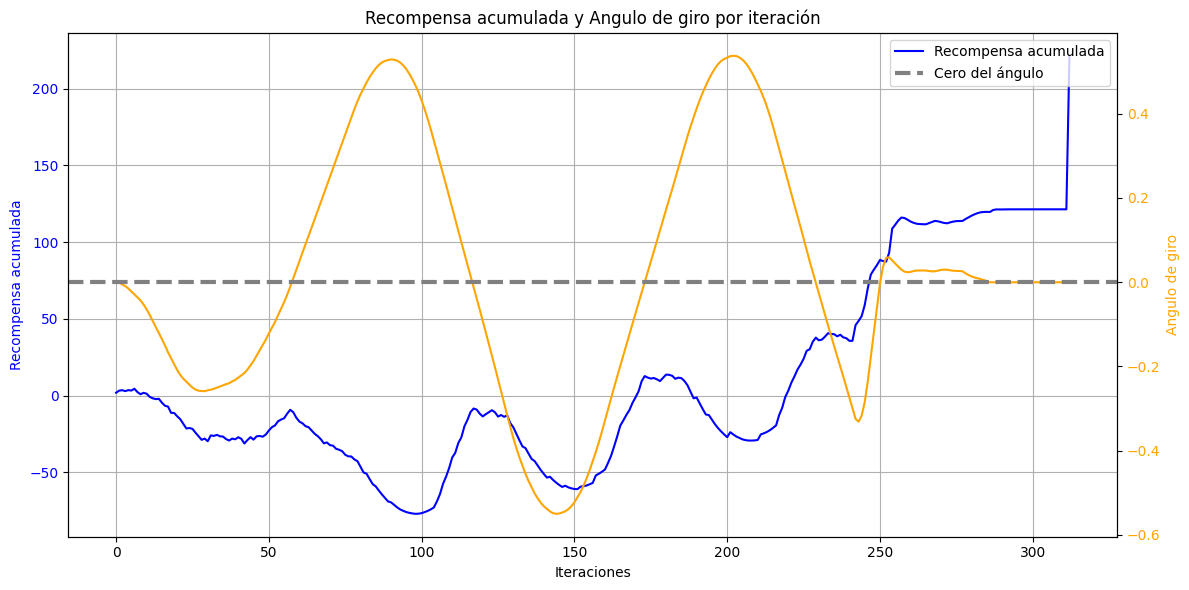

Recompensa:  221.34582413104505


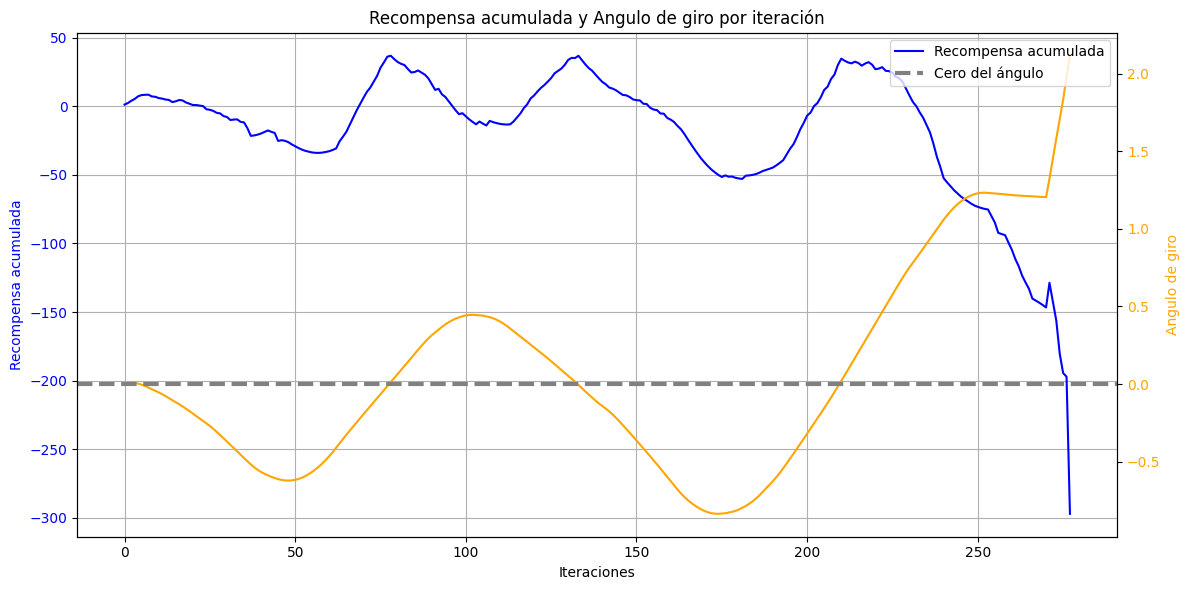

Recompensa:  -297.09009094743874


In [139]:
## Episodio exitoso
recompensa, iteraciones, recompensa_iter, angulo_iteracion = episodios_hasta_exito_o_fallo(True)
plot_recompensa_rotacion(recompensa, iteraciones, recompensa_iter, angulo_iteracion)

## Episodio fallido
recompensa, iteraciones, recompensa_iter, angulo_iteracion = episodios_hasta_exito_o_fallo(False)
plot_recompensa_rotacion(recompensa, iteraciones, recompensa_iter, angulo_iteracion)

Luego de múltiples ejecuciones observando el comportamiento de la nave a lo largo de un episodio, se observa que un factor importante que determina el éxito del episodio es la inclinación del agente a lo largo de las iteraciones, ya que si la nave se inclina demasiado, esta puede entrar en un punto de no retorno, donde no podrá recuperarse y terminará fallando el aterrizaje. Por esto decidimos examinar el angulo de giro tomado por la nave a lo largo de un episodio, y contrastarlo con la recompensa acumulada hasta esa iteración en el episodio.



#### **5.1 Cortes de matriz Q**

La función `state_examples` tiene como objetivo realizar un corte en la matriz Q, extrayendo subconjuntos de valores correspondientes a diferentes combinaciones de estados discretizados que representan situaciones específicas en el entorno del agente. Este corte permite analizar cómo se comporta el agente en esos estados particulares y cómo varían los valores Q para cada acción disponible, o sea, cómo el agente evalúa las acciones en función de la situación en la que se encuentra.

La función recibe varios parámetros que definen los rangos de las características del estado del agente. Dada la división en 20 bins de cada dimensión, cada parámetro tendrá como valor posible un número entero entre 0 y 19 excepto los de contacto de los pies. Los parámetros son:

- **min_x**, **max_x**: Se proporcionan los valores máximo y mínimo de x, donde **x = 0** corresponde al valor mínimo contenido en el bin número 10. Los valores mayores se asignan a bins superiores y los menores a bins inferiores.
- **min_y**, **max_y**: Se incluyen los valores máximo y mínimo de y, siendo **y = 0 a 3** (punto de aterrizaje) el valor mínimo del bin número 1. El valor de inicio en 11
- **delta_x_vel**, **delta_y_vel**: Se definen los rangos de velocidad en los ejes, con el valor nulo de velocidad representado en el bin 10 como el mínimo valor.
- **delta_theta_izq**, **delta_theta_der**, **delta_theta_vel_izq**, **delta_theta_vel_der**: Se especifican tanto el ángulo máximo como el mínimo, así como las velocidades de rotación máxima y mínima. De manera análoga a las velocidades en los ejes x e y, el valor 0 se asocia al bin 10, con las rotaciones en sentido antihorario asignadas a bins mayores y las rotaciones en sentido horario a bins menores.
- **pie_izq_en_contacto**, **pie_der_en_contacto**: Indican si los pies izquierdo o derecho del agente están en contacto con el suelo. 

Dentro de la función, se generan múltiples combinaciones de estos parámetros, que se utilizan para obtener el índice correspondiente en la matriz Q. De estos valores, se descartan todos los estados que nunca hayan sido visitados. Estos índices se calculan con la función `agente.estado_discretizado_a_indice`, detallada previamente en el informe.

Con el propósito de poder analizar el conjunto de datos, se utilizan promedios de recompensa asociados a cada acción de todas las filas extraídas de Q para entender las tendencias en estados similares.


In [40]:
def state_examples(min_x, max_x, min_y, max_y, delta_x_vel, delta_y_vel, theta_izq, theta_der, theta_vel_izq, theta_vel_der, pie_izq_en_contacto, pie_der_en_contacto):
    Rows = []
    for x in range(min_x,max_x):
        for y in range(min_y,max_y):
            for x_vel in range(9-delta_x_vel,11+delta_x_vel):
                for y_vel in range(9-delta_y_vel,11+delta_y_vel):
                    for theta in range(9-theta_der,11+theta_izq):
                        for theta_vel in range(9-theta_vel_der,11+theta_vel_izq):
                            index = (int) (agente.estado_discretizado_a_indice([x,y,x_vel,y_vel,theta,theta_vel,pie_izq_en_contacto,pie_der_en_contacto]))
                            Rows = np.append(Rows, index)
    mRows = np.zeros(((int) (len(Rows)),4))
    for i in range(len(Rows)):
        mRows[i] = agente.Q[(int) (Rows[i])]
    mRows = mRows[np.any(mRows != 0, axis=1)]
    return mRows

Como ejemplo para ilustrar el funcionamiento, se presenta un corte completo de los casos en los que la nave se encuentra centrada en la posición de inicio, sin velocidad ni rotación. Dada una fila, se prefiere aquella acción con mayor recompensa.

In [ ]:
print('Ejemplo')
ejemplo = state_examples(min_x=9, max_x=10, min_y=10, max_y=11, delta_x_vel=0, delta_y_vel=0, theta_izq=0, theta_der=0, theta_vel_izq=0, theta_vel_der=0, pie_izq_en_contacto=0, pie_der_en_contacto=0)
print(len(ejemplo))
print(np.mean(ejemplo, 0))
print(ejemplo)

Luego, con esta función definida, se realizan varios cortes en la matriz Q que, mediante variaciones de los parámetros previamente descritos, describen posibles situaciones en las que podría estar nuestro agente. Luego, obtenemos el promedio de recompensas asociadas a acciones, para poder analizar qué acción tomaría el agente en estas situaciones recopiladas.

In [94]:
# Cayendo
print('Cayendo')
falling = state_examples(min_x=8, max_x=12, min_y=7, max_y=12, delta_x_vel=1, delta_y_vel=3, theta_izq=0, theta_der=0, theta_vel_izq=0, theta_vel_der=0, pie_izq_en_contacto=0, pie_der_en_contacto=0)
print(len(falling))
print(np.mean(falling, 0))

# Hovering
print('Hovering')
hovering = state_examples(min_x=8, max_x=12, min_y=7, max_y=12, delta_x_vel=1, delta_y_vel=1, theta_izq=0, theta_der=0, theta_vel_izq=0, theta_vel_der=0, pie_izq_en_contacto=0, pie_der_en_contacto=0)
print(len(hovering))
print(np.mean(hovering, 0))

# Aterrizando suavemente
print('Aterrizando suavemente')
landing_soft = state_examples(min_x=8, max_x=12, min_y=0, max_y=4, delta_x_vel=0, delta_y_vel=0, theta_izq=0, theta_der=0, theta_vel_izq=0, theta_vel_der=0, pie_izq_en_contacto=0, pie_der_en_contacto=0)
print(len(landing_soft))
print(np.mean(landing_soft, 0))

# En el piso
print('En el piso')
floor = state_examples(min_x=0, max_x=20, min_y=0, max_y=9, delta_x_vel=1, delta_y_vel=0, theta_izq=0, theta_der=0, theta_vel_izq=0, theta_vel_der=0, pie_izq_en_contacto=1, pie_der_en_contacto=1)
print(len(floor))
print(np.mean(floor,0))


# Girando hacia la derecha en el aire
print('Girando hacia la derecha en el aire')
falling_spinning = state_examples(min_x=4, max_x=16, min_y=4, max_y=12, delta_x_vel=1, delta_y_vel=1, theta_izq=-5, theta_der=5, theta_vel_izq=-2, theta_vel_der=5, pie_izq_en_contacto=0, pie_der_en_contacto=0)
print(len(falling_spinning))
print(np.mean(falling_spinning, 0))



Cayendo
876
[6.54883408 6.11443226 7.82653238 6.12750318]
Hovering
778
[6.9953692  6.72525288 8.33412566 6.68858218]
Aterrizando suavemente
243
[12.45004258 11.96925871 12.48665587 12.48289429]
En el piso
598
[-7.67874006 -5.4855052  -5.60805611 -4.02071994]
Girando hacia la derecha en el aire
229
[-6.90974617 -5.20429645 -6.5130861  -4.50413346]


Las acciones representan las columnas de la matriz; de izquierda a derecha se enumeran de la siguiente manera: no tomar acciones, prender el propulsor izquierdo, prender el propulsor principal y prender el propulsor derecho. A través de los promedios de las columnas de filas que corresponden a estados similares, podemos analizar el comportamiento adoptado en estos conjuntos de casos.

En el primer caso, cuando la nave está cayendo con poca rotación, se observa que la acción con mayor recompensa es la de prender el propulsor principal, con el objetivo de reducir la velocidad vertical. Es relevante señalar que la segunda acción con mayor recompensa es no hacer nada, lo que sugiere que es preferible seguir cayendo de manera recta antes de inclinarse al activar los propulsores laterales.

De manera análoga, cuando la nave presenta poca velocidad vertical, escasa rotación y se encuentra centrada horizontalmente en el aire, la política indica que debe activarse el propulsor principal. Creemos que esta estrategia es lo que lleva al flotar quieto que hemos notado al ejecutar episodios.

Por otro lado, al aterrizar correctamente, se manifiesta una alta preferencia no solo por activar el propulsor principal, sino también por no tomar acciones. Además, todas las acciones muestran un valor positivo, ya que, si la nave aterriza adecuadamente, obtendrá una recompensa considerable.

En el penúltimo caso, cuando la nave está en contacto con el suelo, la acción de no tomar acciones presenta el menor valor. Esto se evidencia en el comportamiento de la nave, que continúa activando los propulsores a pesar de tener ambos pies en contacto con el piso.